# Exploring OpenEEW data

## Import openeew package

In [1]:
from openeew.data.aws import AwsDataClient
from openeew.data.df import get_df_from_records

## Import other packages

In [2]:
import folium
from datetime import datetime
import plotnine as pn
import pandas as pd
from geopy.distance import distance

## Get past earthquake date and location

In [3]:
# Check SSN website:
# http://www2.ssn.unam.mx:8080/sismos-fuertes/

eq = {
    'latitude': 16.218,
    'longitude': -98.0135,
    'date_utc': '2018-02-16 23:39:39'
    }

## View epicenter on map

In [4]:
m = folium.Map(
        location=[eq['latitude'], eq['longitude']],
        zoom_start=7
        )

folium.Circle(
    radius=10000,
    location=[eq['latitude'], eq['longitude']],
    color='crimson',
    fill='crimson',
    ).add_to(m)

In [5]:
m

## Initialize OpenEEW data client

In [6]:
data_client = AwsDataClient('mx')

## Get devices as of earthquake date

In [7]:
devices = data_client.get_devices_as_of_date(eq['date_utc'])

In [8]:
devices

[{'country_code': 'mx',
  'device_id': '000',
  'latitude': 19.33,
  'longitude': -99.18,
  'effective_from': 1483228800.0,
  'effective_to': 1542758400.0,
  'is_current_row': False,
  'vertical_axis': 'x',
  'horizontal_axes': ['y', 'z']},
 {'country_code': 'mx',
  'device_id': '001',
  'latitude': 15.67,
  'longitude': -96.5,
  'effective_from': 1483228800.0,
  'effective_to': 253402300799.0,
  'is_current_row': True,
  'vertical_axis': 'x',
  'horizontal_axes': ['y', 'z']},
 {'country_code': 'mx',
  'device_id': '002',
  'latitude': 15.87,
  'longitude': -97.07,
  'effective_from': 1483228800.0,
  'effective_to': 1521655199.0,
  'is_current_row': False,
  'vertical_axis': 'x',
  'horizontal_axes': ['y', 'z']},
 {'country_code': 'mx',
  'device_id': '004',
  'latitude': 16.35,
  'longitude': -98.05,
  'effective_from': 1483228800.0,
  'effective_to': 253402300799.0,
  'is_current_row': True,
  'vertical_axis': 'x',
  'horizontal_axes': ['y', 'z']},
 {'country_code': 'mx',
  'device_i

In [9]:
for d in devices:
    folium.Marker(
        [d['latitude'], d['longitude']],
        popup = folium.Popup(
            d['device_id'],
            sticky=True
            )
        ).add_to(m)

In [10]:
m

## Get records for date range

In [11]:
# For generality we could calculate
# these dates based on the eq date
start_date_utc = '2018-02-16 23:39:00'
end_date_utc = '2018-02-16 23:43:00'

records_df = get_df_from_records(
    data_client.get_filtered_records(
        start_date_utc,
        end_date_utc
        )
    )


# Get UTC date from Unix time sample_t for plotting
records_df['sample_dt'] = \
    records_df['sample_t'].apply(lambda x: datetime.utcfromtimestamp(x))

# Select required columns
records_df = records_df[
    [
        'device_id',
        'x',
        'y',
        'z',
        'sample_dt'
        ]
    ]

In [12]:
records_df.head()

,device_id,x,y,z,sample_dt
0,000,-0.155,0.158,0.015,2018-02-16 23:38:59.602
1,000,-0.128,0.158,0.128,2018-02-16 23:38:59.634
2,000,-0.158,0.128,0.068,2018-02-16 23:38:59.666
3,000,-0.177,0.128,0.121,2018-02-16 23:38:59.698
4,000,-0.132,0.177,0.102,2018-02-16 23:38:59.730


## Plot records for single device

In [13]:
def plot_seismograms(device_id):
    
    # Get earthquake date as datetime.datetime object
    eq_dt = AwsDataClient._get_dt_from_str(eq['date_utc'])

    plots = []
    for axis in ['x', 'y', 'z']:
        plots.append(
            pn.ggplot(
                records_df[records_df['device_id'] == device_id],
                pn.aes('sample_dt', axis)
                ) + \
            pn.geom_line(color='blue') + \
            pn.scales.scale_x_datetime(
                date_breaks='1 minute',
                date_labels='%H:%M:%S'
                ) + \
            pn.geoms.geom_vline(
                xintercept=eq_dt,
                color='crimson'
                ) + \
            pn.labels.ggtitle('device {}, axis {}'.format(device_id, axis))
        )
        
    for p in plots:
        print(p)

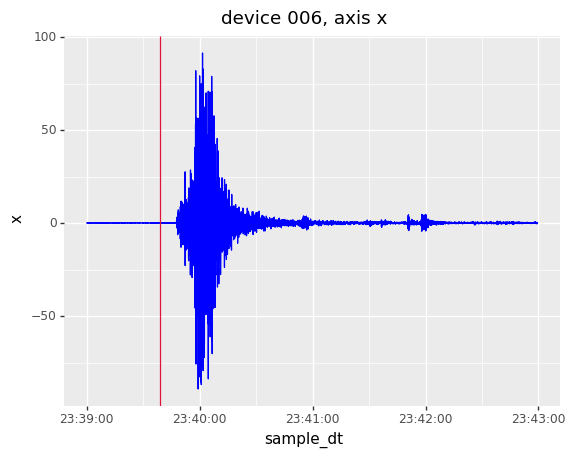

<ggplot: (-9223363269667399150)>


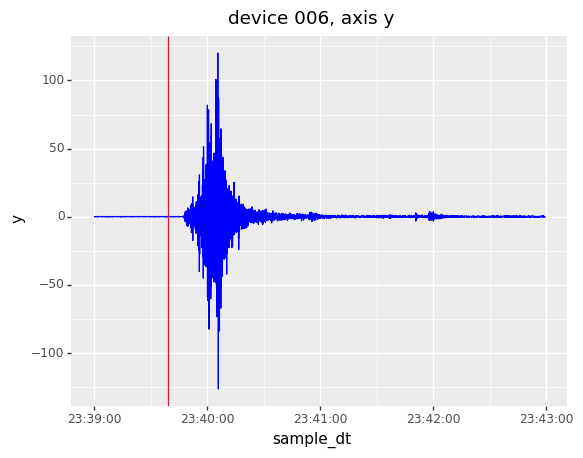

<ggplot: (8767188538930)>


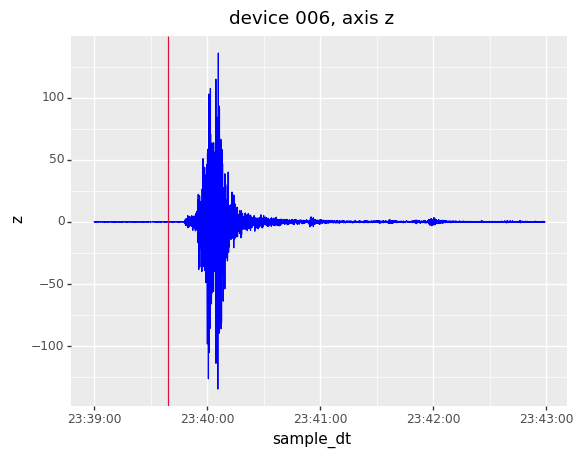

<ggplot: (8767187372194)>


In [14]:
plot_seismograms('006')

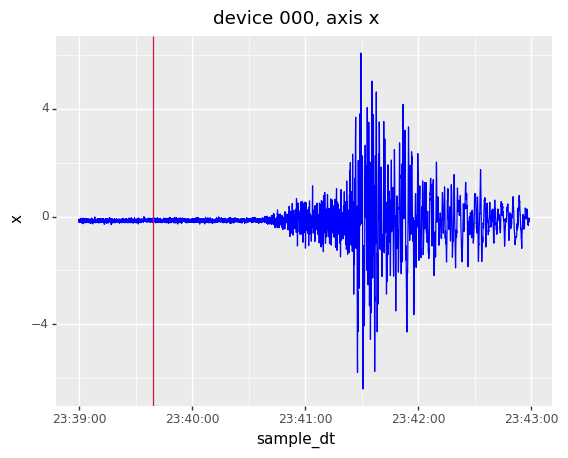

<ggplot: (-9223363269667590691)>


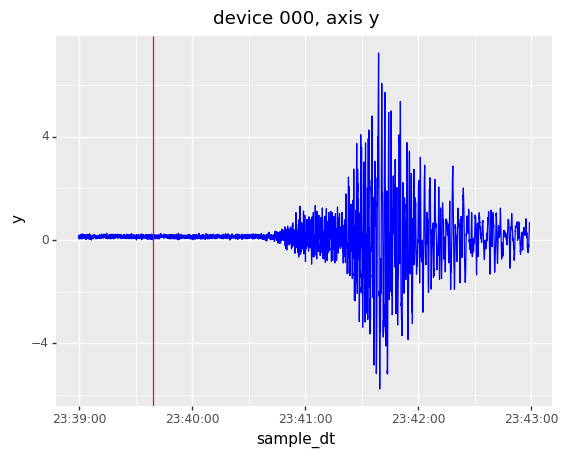

<ggplot: (-9223363269667422418)>


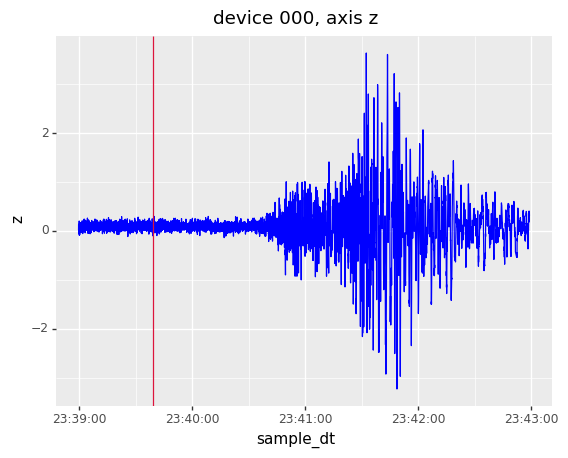

<ggplot: (8767187415251)>


In [15]:
plot_seismograms('000')

## Compare max accelerations

In [16]:
# For each device, get max acceleration of horizontal axes
# Store these values as pandas Series
pgas = pd.Series(name='pga')
pgas.index.name = 'device_id'

for device_id in records_df.device_id.unique():
    # Get horizontal axes from device metadata
    horizontal_axes = [
        d['horizontal_axes'] for d in devices
        if d['device_id'] == device_id
    ][0]

    # Get max accel as sqrt of sum of squares of horizontal axes
    pgas[device_id] = \
        (records_df[records_df['device_id'] == device_id][horizontal_axes] ** 2) \
        .sum(axis=1) \
        .pow(0.5) \
        .max()

In [17]:
pgas = pgas.sort_values(ascending=False)
pgas

device_id
006    185.732785
009     51.173328
010     36.387814
008     29.550905
011     13.337869
001     13.334694
015     11.725299
014      9.611825
000      7.647946
016      6.120672
018      3.722081
017      3.607924
012      2.964899
020      2.936600
023      2.367198
013      2.356711
Name: pga, dtype: float64

## Compare relationship between distance and max acceleration

In [18]:
# Use a pandas DataFrame for convenience
devices_df = pd.DataFrame(devices)

devices_df = devices_df[
    [
        'device_id',
        'latitude',
        'longitude'
    ]
]

# Use the geopy.distance.distance function
# to get distance from devices to epicenter
devices_df['dist_from_eq'] = devices_df.apply(
    lambda r: round(
        distance(
            (r['latitude'], r['longitude']),
            (eq['latitude'], eq['longitude'])
            ).km, 3),
        axis=1
    )

devices_df = devices_df.merge(pgas, left_on='device_id', right_index=True)

In [19]:
devices_df.sort_values('dist_from_eq')

,device_id,latitude,longitude,dist_from_eq,pga
5,006,16.68,-98.40,65.708,185.732785
7,008,16.61,-98.98,111.977,29.550905
8,009,16.72,-99.12,130.561,51.173328
9,010,16.80,-99.39,160.447,36.387814
1,001,15.67,-96.50,173.016,13.334694
10,011,16.84,-99.90,212.818,13.337869
13,014,16.87,-99.89,212.895,9.611825
14,015,17.01,-100.09,238.268,11.725299
15,016,17.14,-100.47,281.184,6.120672
16,017,17.23,-100.63,300.656,3.607924


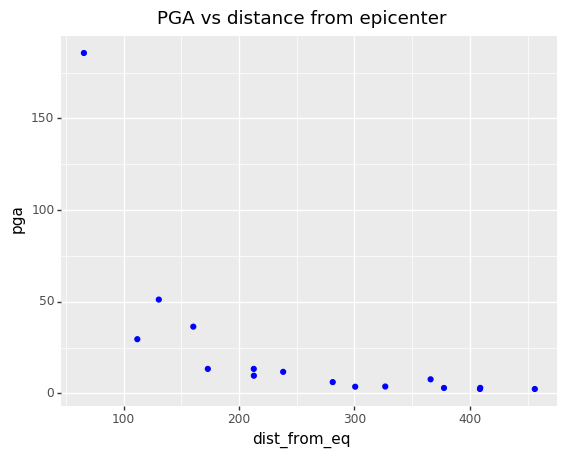

<ggplot: (-9223363269667883958)>

In [20]:
# Plot using linear scale
pn.ggplot(
        devices_df,
        pn.aes('dist_from_eq', 'pga')
        ) + \
    pn.geom_point(color='blue') + \
    pn.labels.ggtitle('PGA vs distance from epicenter')
